In [0]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCLoader(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=r'/content/drive/My Drive/benchmark_RELEASE',
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path).convert('RGB')
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, lbl

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        path = pjoin(sbd_path, "dataset/train.txt")
        sbd_train_list = tuple(open(path, "r"))
        sbd_train_list = [id_.rstrip() for id_ in sbd_train_list]
        train_aug = self.files["train"] + sbd_train_list

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")
            for ii in tqdm(sbd_train_list):
                lbl_path = pjoin(sbd_path, "dataset/cls", ii + ".mat")
                data = io.loadmat(lbl_path)
                lbl = data["GTcls"][0]["Segmentation"][0].astype(np.int32)
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, ii + ".png"), lbl)

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 9733, "unexpected dataset sizes"





In [0]:
import sys
sys.path.append(r'/content/drive/My Drive/pytorch-semseg-master/ptsemseg')
sys.path.append(r'/content/drive/My Drive/pytorch-semseg-master/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


KeyboardInterrupt: ignored

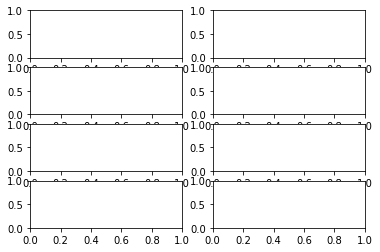

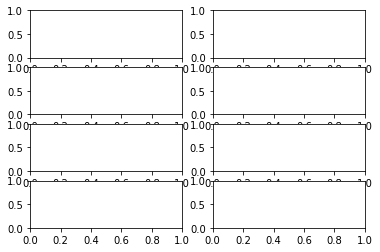

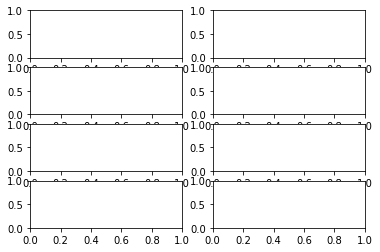

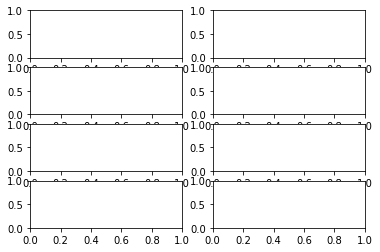

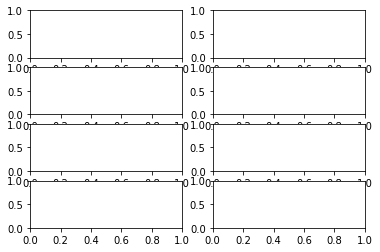

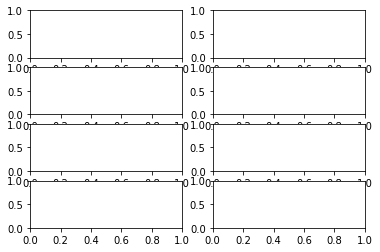

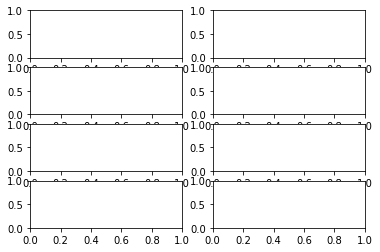

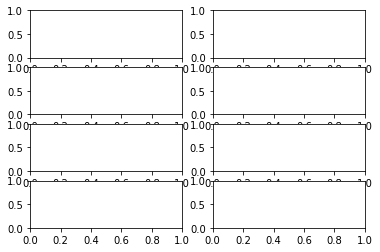

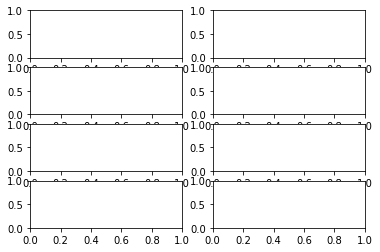

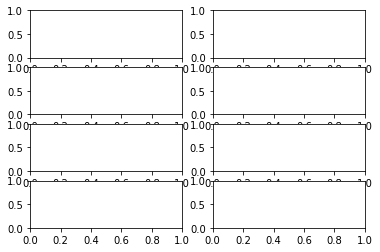

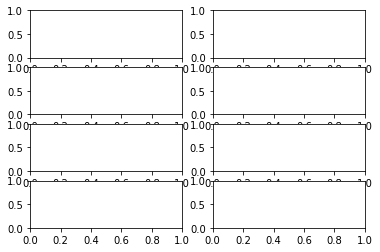

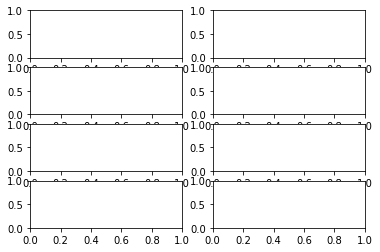

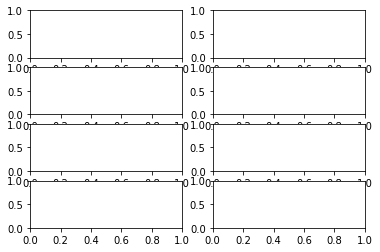

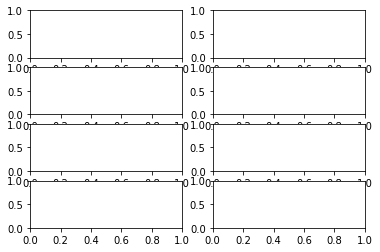

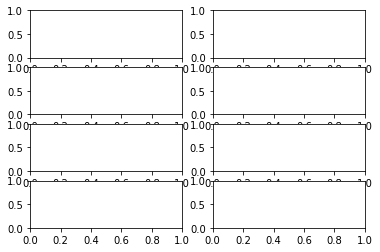

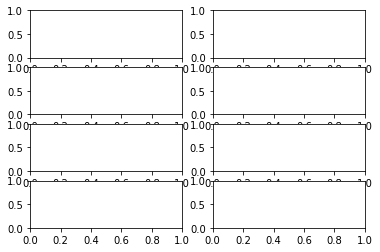

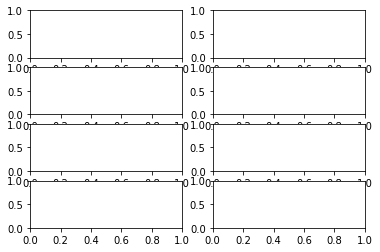

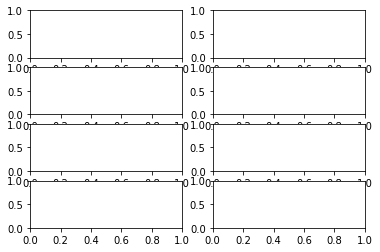

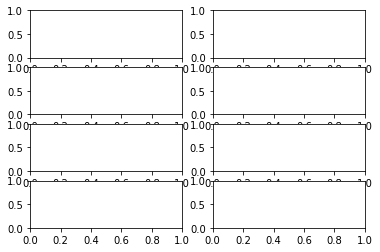

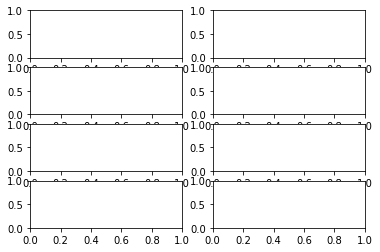

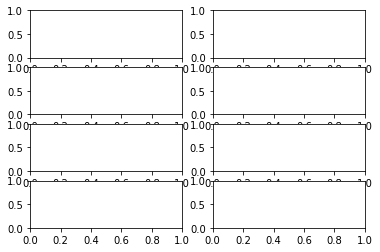

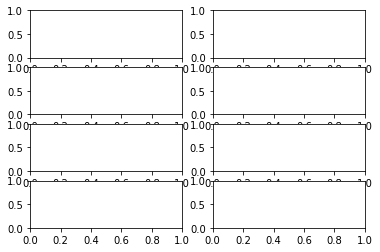

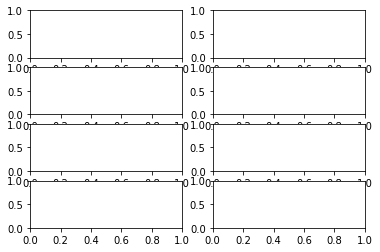

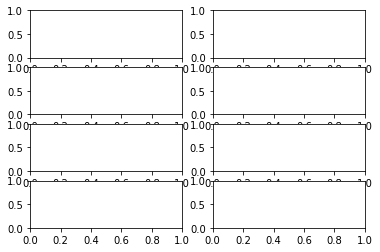

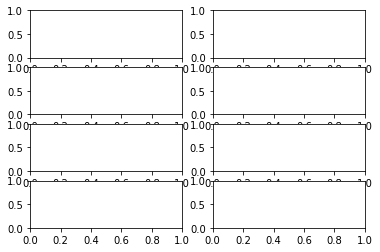

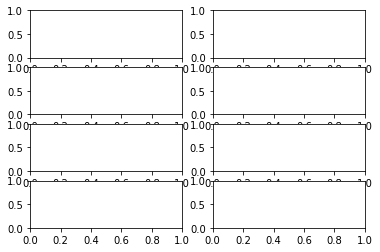

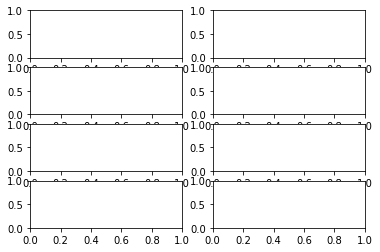

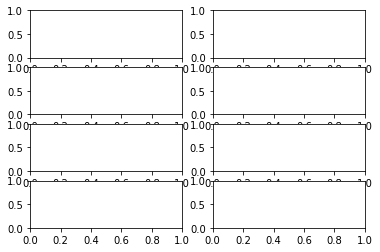

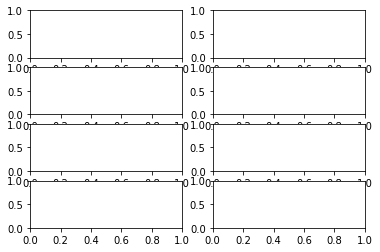

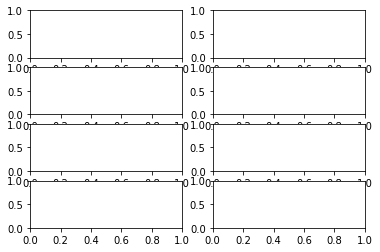

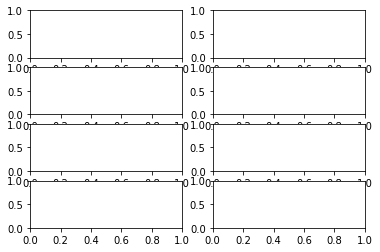

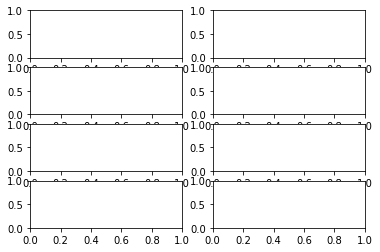

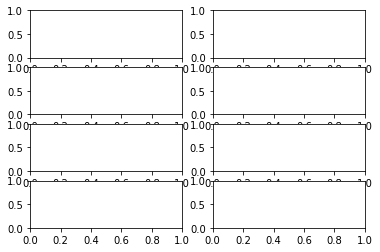

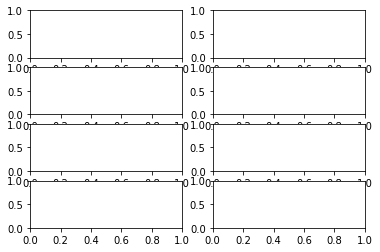

In [12]:

import ptsemseg.augmentations as aug
if __name__ == '__main__':
    local_path = r'/content/drive/My Drive/VOCdevkit/VOC2012'
    bs = 4
    # augs = aug.Compose([aug.RandomRotate(10), aug.RandomHorizontallyFlip()])
    dst = pascalVOCLoader(root=local_path, is_transform=True)
    trainloader = data.DataLoader(dst, batch_size=bs)
    for i, data in enumerate(trainloader):
        imgs, labels = data
        imgs = imgs.numpy()[:, ::-1, :, :]
        imgs = np.transpose(imgs, [0,2,3,1])
        f, axarr = plt.subplots(bs, 2)
    for j in range(bs):
        axarr[j][0].imshow(imgs[j])
        axarr[j][1].imshow(dst.decode_segmap(labels.numpy()[j]))
        plt.show()
        a = raw_input()
        if a == 'ex':
            break
        else:
            plt.close()